## **H1N1 AND SEASONAL PREDICTIVE MODELLING**

### **BUSINESS UNDERSTANDING**

The business problem centers on leveraging data from the 2009 H1N1 Flu Survey, conducted during and after the "swine flu" pandemic. There was a lower uptake of the H1N1 vaccine which presents a key area of interest. By analyzing the survey responses on vaccination status against demographic and socio-economic factors, the goal is to gain actionable insights into the drivers and barriers influencing vaccine adoption during a pandemic. This understanding is crucial for informing public health strategies aimed at improving vaccination rates for future pandemics.


### **DATA UNDERSTANDING**

In [57]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, log_loss, roc_auc_score, roc_curve, auc, make_scorer
from sklearn.feature_selection import RFECV, RFE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE

In [58]:
# load the features dataframe
df_x = pd.read_csv('data/training_set_features.csv', index_col=0)
df_x.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [59]:
# load the targets dataframe
df_y = pd.read_csv('data/training_set_labels.csv', index_col=0)
df_y.head()

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [60]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker        

In [61]:
categorical_columns = categorical_columns = df_x.select_dtypes(exclude=['number']).columns
categorical_columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

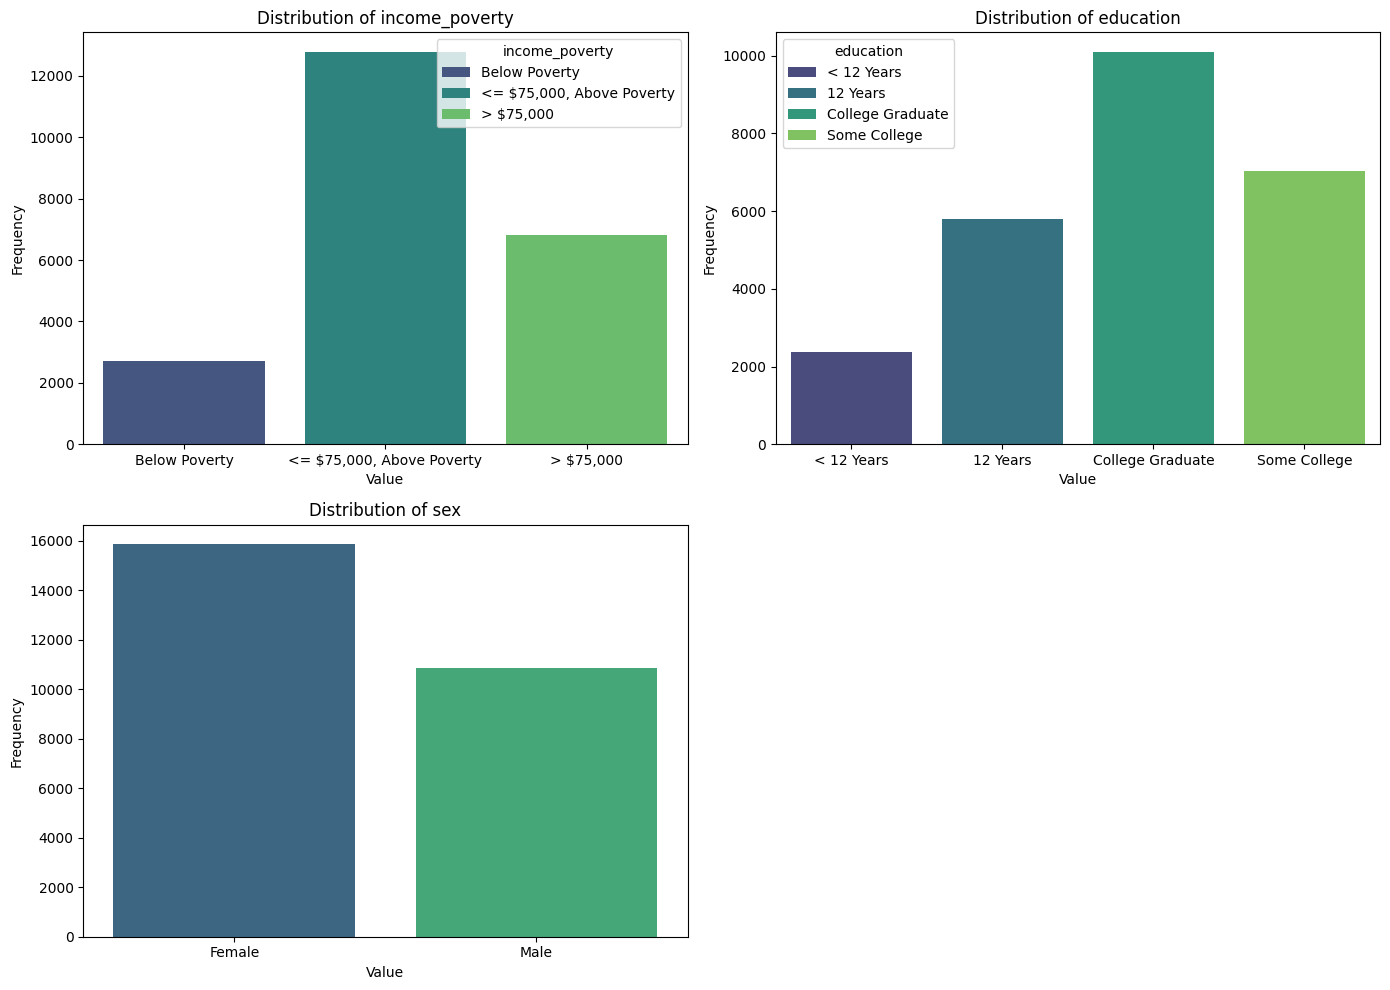

In [62]:
columns = ['income_poverty', 'education', 'sex']

plt.figure(figsize=(14, 10))  

for i, column in enumerate(columns):
    plt.subplot(2, 2, i +1) 
    sns.countplot(data=df_x, x=column, hue=column, palette='viridis')

    plt.title(f'Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

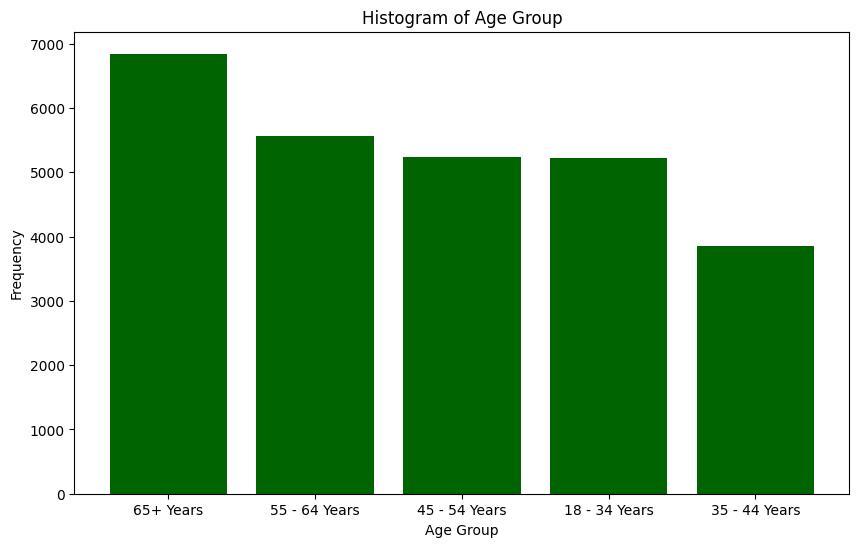

In [63]:
# distribution of age groups
age_group = df_x['age_group'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(age_group.index, age_group.values, color='darkgreen')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Histogram of Age Group')

plt.show()

* Majority of respondents are college students, people who live above poverty level, people who identify with the female gender or people who are 65+ years of age

### **DATA PREPARATION AND PREPROCESSING**

* We will begin by splitting our data to avoid data leakage

In [64]:
# check for missing values in target dataset
df_y.isnull().any()

h1n1_vaccine        False
seasonal_vaccine    False
dtype: bool

In [65]:
# defining X and y
X = df_x
y = df_y[['h1n1_vaccine', 'seasonal_vaccine']]

# splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

In [66]:
missing_values = X_train.isnull().sum()

missing_values.sort_values(ascending=False)

employment_occupation          9344
employment_industry            9250
health_insurance               8624
income_poverty                 3090
doctor_recc_seasonal           1473
doctor_recc_h1n1               1473
rent_or_own                    1406
employment_status              1020
education                       983
marital_status                  973
chronic_med_condition           664
child_under_6_months            583
health_worker                   567
opinion_seas_sick_from_vacc     374
opinion_seas_risk               366
opinion_seas_vacc_effective     323
opinion_h1n1_vacc_effective     285
opinion_h1n1_sick_from_vacc     280
opinion_h1n1_risk               274
household_adults                178
household_children              178
behavioral_avoidance            147
behavioral_touch_face            85
h1n1_knowledge                   81
h1n1_concern                     65
behavioral_large_gatherings      56
behavioral_outside_home          55
behavioral_antiviral_meds   

In [67]:
# drop columns 
drop_columns = ['rent_or_own', 'race', 'marital_status', 'employment_occupation', 'employment_industry']
X_train = X_train.drop(drop_columns, axis=1)
X_test = X_test.drop(drop_columns, axis=1)

In [68]:
numerical_columns = df_x.select_dtypes(include=np.number).columns
numerical_columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children'],
      dtype='object')

In [69]:
# fill numerical missing data with their modes using simpleimputer
fill_numerical = ['health_insurance', 'doctor_recc_h1n1', 'doctor_recc_seasonal']

impute_number = SimpleImputer(strategy='most_frequent')

X_train[fill_numerical] = impute_number.fit_transform(X_train[fill_numerical])
X_test[fill_numerical] = impute_number.transform(X_test[fill_numerical])


In [70]:
categorical_columns = df_x.select_dtypes(exclude=['number']).columns
categorical_columns

Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object')

In [71]:
# fill categorical missing data with 
fill_categorical =  ['employment_status']

imputer_object = SimpleImputer(strategy='constant',missing_values=np.nan,fill_value='missing')

X_train[fill_categorical] = imputer_object.fit_transform(X_train[fill_categorical])
X_test[fill_categorical] = imputer_object.transform(X_test[fill_categorical])

In [72]:
# drop rows with missing values
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

In [73]:
# drop same indexes that have been dropped in X_train and X_test
set1 = set(y_test.index)
set2 = set(X_test.index)
set3 = set(y_train.index)
set4 = set(X_train.index)

index_to_drop_test = list(set1 - set2)
index_to_drop_train = list(set3 - set4)

y_test = y_test.drop(index_to_drop_test)
y_train = y_train.drop(index_to_drop_train)

In [74]:
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

Shape of X_train: (15018, 30)
Shape of y_train: (15018, 2)


Encoding Categorical Features

In [75]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Added handle_unknown for robustness
columns = ['age_group', 'education', 'sex', 'income_poverty', 'hhs_geo_region', 'census_msa', 'employment_status']
ohe_train = ohe.fit_transform(X_train[columns])
ohe_test = ohe.transform(X_test[columns])

feature_names = ohe.get_feature_names_out(input_features=columns)

X_train_encoded = pd.DataFrame(ohe_train, index=X_train.index, columns=feature_names)
X_test_encoded = pd.DataFrame(ohe_test, index=X_test.index, columns=feature_names)

X_train = pd.concat([X_train.drop(columns=columns), X_train_encoded], axis=1)
X_test = pd.concat([X_test.drop(columns=columns), X_test_encoded], axis=1)


Scaling numerical features to ensure they are all in the same range

In [76]:
# scaling numerical columns
scaling_columns_train = X_train.select_dtypes(include=['number']).columns
scaling_columns_test = X_test.select_dtypes(include=['number']).columns

scaler = StandardScaler()

X_train[scaling_columns_train] = scaler.fit_transform(X_train[scaling_columns_train])
X_test[scaling_columns_test] = scaler.transform(X_test[scaling_columns_test])

### MODELLING

#### **LOGISTIC REGRESSION**

This section look at the iterative modelling process in a bid to arrive at one with the highest accuracy on the test data

**Baseline Model**

In [77]:
# instantiate the base logistic regression
lr = LogisticRegression(solver='saga', random_state=42)

# instantiate the MultiOutputClassifier
baseline_model = MultiOutputClassifier(lr)

# fitting the multilabel model
baseline_model.fit(X_train, y_train)

# predict for the test set
y_pred_test = baseline_model.predict(X_test)

y_test_np = y_test.values
y_pred_test_np = y_pred_test


for i in range(y_test_np.shape[1]):
    print(f'Classification Report for Output {i}:')
    print(classification_report(y_test_np[:, i], y_pred_test_np[:, i], zero_division=0))
    print('\n.......\n')

Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5040
           1       0.70      0.44      0.54      1390

    accuracy                           0.84      6430
   macro avg       0.78      0.70      0.72      6430
weighted avg       0.83      0.84      0.82      6430


.......

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3441
           1       0.77      0.75      0.76      2989

    accuracy                           0.78      6430
   macro avg       0.78      0.78      0.78      6430
weighted avg       0.78      0.78      0.78      6430


.......



* The model is comfortable predicting individuals who did not get h1n1 vaccine but is struggling with predicting individuals who got it.
* The seasonal vaccine metrics are well balanced but accuracy could be improved

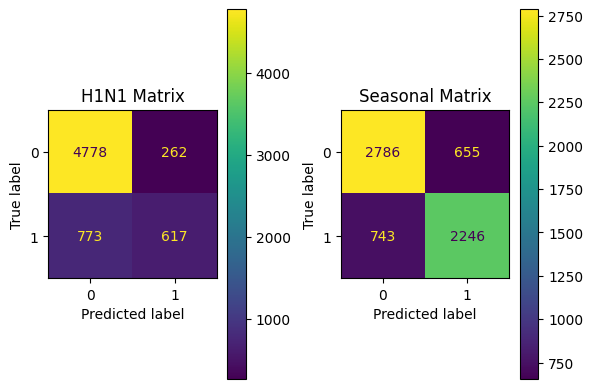

In [78]:
# confusion matrix for H1N1 vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred_test[:, 0])

# confusion matrix  for Seasonal vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred_test[:, 1])
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot h1n1 and seasonal vaccine confusion matrix
display_1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1)
display_2 = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal)

display_1.plot(ax=axes[0])
axes[0].set_title('H1N1 Matrix')

display_2.plot(ax=axes[1])
axes[1].set_title('Seasonal Matrix')

plt.tight_layout()
plt.show()


In [79]:
# function for plotting the ROC curve
def plot_roc_curve(model, X_test, y_test):
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_prob_test = model.predict_proba(X_test)

    plt.figure(figsize=(6, 4))
    for i in range(n_classes):  
        y_test_label = y_test.iloc[:, i].values
        y_score_label = y_prob_test[i][:, 1]

        fpr[i], tpr[i], _ = roc_curve(y_test_label, y_score_label)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (label {i}, area = {roc_auc[i]:.2f})')


    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    print('AUC: {}'.format(roc_auc))
    plt.show()



AUC: {0: np.float64(0.8403333047847438), 1: np.float64(0.8572045966470684)}


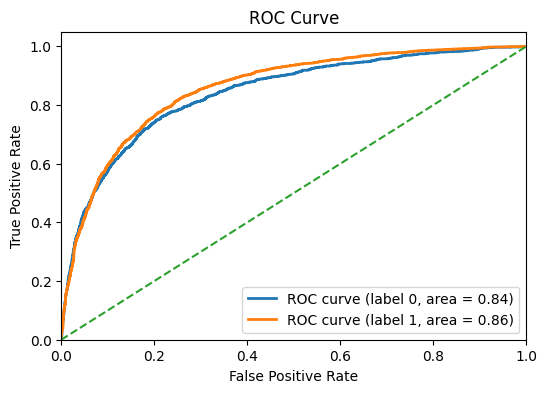

In [80]:
plot_roc_curve(baseline_model, X_test, y_test)

Hyperparameter Tuning

In [81]:
# change parameter to handle class imbalance
alternative =  LogisticRegression( solver= 'lbfgs', class_weight= 'balanced', C=1, max_iter=500, random_state=42)
alternative_model = MultiOutputClassifier(alternative)

alternative_model.fit(X_train, y_train)

y_pred_alt = alternative_model.predict(X_test)

y_test_np = y_test.values
y_pred_alt_np = y_pred_alt


for i in range(y_test_np.shape[1]):
    print(f'Classification Report for Output {i}:')
    print(classification_report(y_test_np[:, i], y_pred_alt_np[:, i], zero_division=0))
    print('\n.......\n')

Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      5040
           1       0.50      0.75      0.60      1390

    accuracy                           0.78      6430
   macro avg       0.71      0.77      0.73      6430
weighted avg       0.83      0.78      0.80      6430


.......

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80      3441
           1       0.76      0.78      0.77      2989

    accuracy                           0.78      6430
   macro avg       0.78      0.78      0.78      6430
weighted avg       0.78      0.78      0.78      6430


.......



* The H1N1 class 1 f1 score has increased but the precision has decreased meaning improved performance on individuals taking the vaccine but the prediction probability of it being correct has decreased.
* The seasonal model has minor changes but remains consistent

AUC: {0: np.float64(0.8411525065661756), 1: np.float64(0.8572286118557932)}


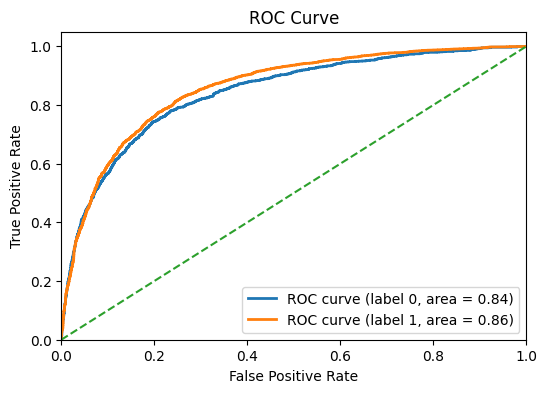

In [82]:

plot_roc_curve(alternative_model, X_test, y_test)

* The H1N1 AUC  has slightly increased suggesting a slight improvement in the new model and the seasonal AUC is still the same

Use GridSearchCV to look for the best parameters

In [83]:
# find the optimal parameters 
final_logistic = LogisticRegression()

param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],
    'max_iter': [500, 1000, 2000, 3000]
}

# find the best parameters for seasonal vaccine
# instantiate the GridSearchCV
grid_search_seasonal = GridSearchCV(final_logistic, param_grid, cv=5)
grid_search_seasonal.fit(X_train, y_train['seasonal_vaccine'])

optimal_params_seasonal = grid_search_seasonal.best_params_
optimal_params_seasonal

{'C': 0.1, 'max_iter': 500}

In [84]:
# find the best parameters for modelling an improved H1N1 model
grid_search_h1n1 = GridSearchCV(final_logistic, param_grid, cv=5)
grid_search_h1n1.fit(X_train, y_train['h1n1_vaccine'])

optimal_params_h1n1 = grid_search_h1n1.best_params_
optimal_params_h1n1

{'C': 1.0, 'max_iter': 500}

In [85]:
# model h1n1 best parameters
best_model_h1n1 = grid_search_h1n1.best_estimator_

y_pred_h1n1 = best_model_h1n1.predict(X_test)

print(classification_report(y_test['h1n1_vaccine'], y_pred_h1n1, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5040
           1       0.70      0.44      0.54      1390

    accuracy                           0.84      6430
   macro avg       0.78      0.70      0.72      6430
weighted avg       0.83      0.84      0.83      6430



In [86]:
# handle class imbalance by adjusting class weight
improved_model_h1n1 = LogisticRegression(C=1, class_weight={0:1, 1:2}, max_iter=500, random_state=42)
improved_model_h1n1.fit(X_train, y_train['h1n1_vaccine'])

y_pred_h1n1_im = improved_model_h1n1.predict(X_test)

print(classification_report(y_test['h1n1_vaccine'], y_pred_h1n1_im, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      5040
           1       0.59      0.61      0.60      1390

    accuracy                           0.82      6430
   macro avg       0.74      0.75      0.74      6430
weighted avg       0.83      0.82      0.82      6430



* The precision of class 1 has improved indicating reduced instances of incorrectly identifying an individual getting the h1n1 vaccine
* The overall accuracy has improved.

In [87]:
# model sesonal best parameters
best_model_seasonal = grid_search_seasonal.best_estimator_

y_pred_seasonal = best_model_seasonal.predict(X_test)

print(classification_report(y_test['seasonal_vaccine'], y_pred_seasonal, zero_division=0))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      3441
           1       0.77      0.75      0.76      2989

    accuracy                           0.78      6430
   macro avg       0.78      0.78      0.78      6430
weighted avg       0.78      0.78      0.78      6430



* The seasonal model has remained stable and balanced.


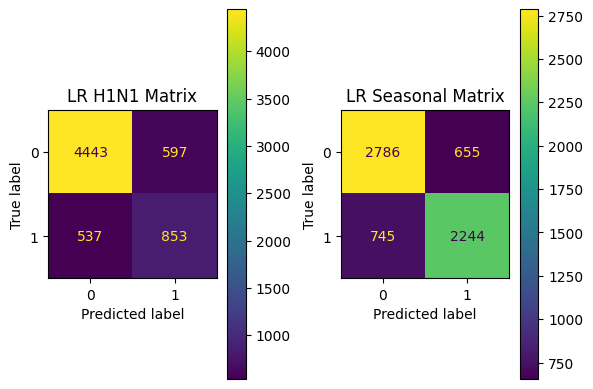

In [88]:
# confusion matrix for optimal h1n1 model
cm_optimal_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred_h1n1_im)

# confusion matrix  for optimal Seasonal vaccine model
cm_optimal_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred_seasonal)
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot h1n1 and seasonal vaccine confusion matrix
display_1 = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_h1n1)
display_2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_seasonal)

display_1.plot(ax=axes[0])
axes[0].set_title('LR H1N1 Matrix')

display_2.plot(ax=axes[1])
axes[1].set_title('LR Seasonal Matrix')

plt.tight_layout()
plt.show()


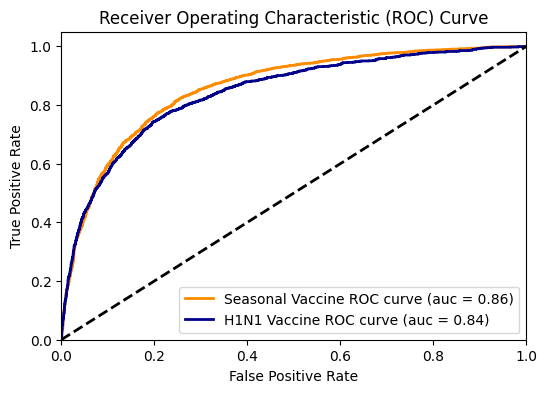

In [91]:
# plot roc curve
y_pred_proba_h1n1_im = improved_model_h1n1.predict_proba(X_test)[:, 1]
y_pred_proba_seasonal = best_model_seasonal.predict_proba(X_test)[:, 1]

fpr_seasonal, tpr_seasonal, thresholds_seasonal = roc_curve(y_test['seasonal_vaccine'], y_pred_proba_seasonal)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

fpr_h1n1, tpr_h1n1, thresholds_h1n1 = roc_curve(y_test['h1n1_vaccine'], y_pred_proba_h1n1_im)
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

plt.figure(figsize=(6, 4))
plt.plot(fpr_seasonal, tpr_seasonal, color='darkorange', lw=2, label=f'Seasonal Vaccine ROC curve (auc = {roc_auc_seasonal:.2f})')
plt.plot(fpr_h1n1, tpr_h1n1, color='darkblue', lw=2, label=f'H1N1 Vaccine ROC curve (auc = {roc_auc_h1n1:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

* Both models are capable of classifying individuals who took the vaccine but the seasonal model is slightly better

In [92]:
# creating a dataframe of feature importances in logistic regression
feature_names = X_train.columns.tolist()
importances_h1n1_lr = improved_model_h1n1.coef_[0]

h1n1_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_h1n1_lr
})
h1n1_df_lr = h1n1_df_lr.sort_values(by='Importance', ascending=False).reset_index(drop=True)
h1n1_df_lr.head()

,Feature,Importance
0,doctor_recc_h1n1,0.838159
1,opinion_h1n1_vacc_effective,0.653355
2,opinion_h1n1_risk,0.504994
3,health_worker,0.276015
4,opinion_seas_risk,0.200704


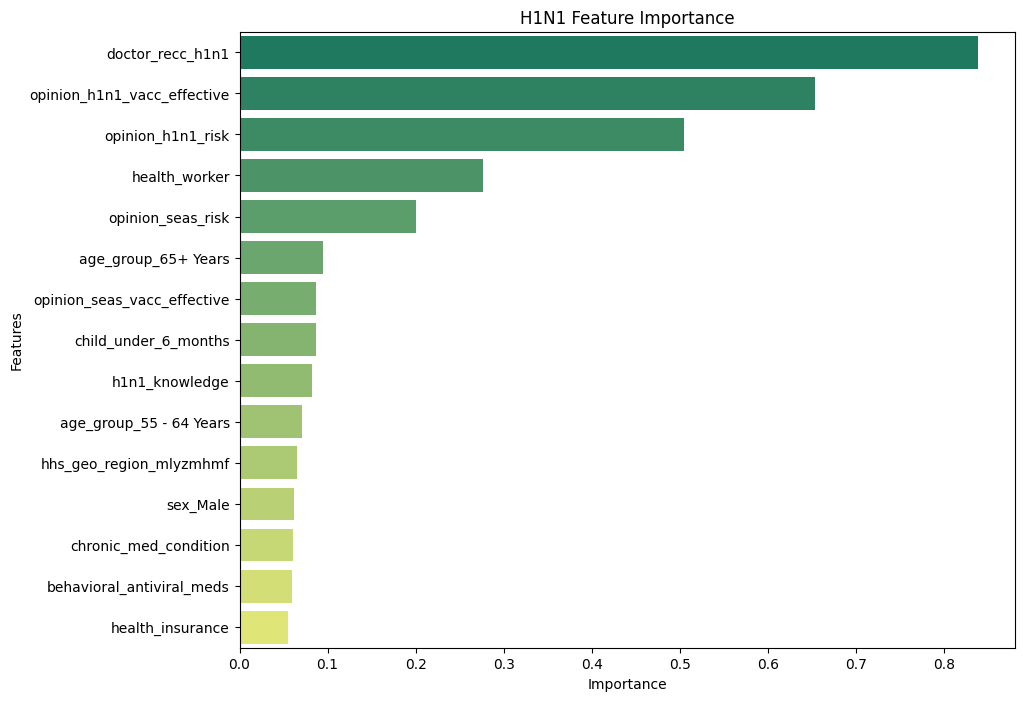

In [93]:
fig,ax = plt.subplots(figsize = (10, 8))

sns.barplot(x=h1n1_df_lr['Importance'][:15], y= h1n1_df_lr['Feature'][:15], hue=h1n1_df_lr['Feature'][:15], palette='summer', ax=ax)
ax.set_ylabel("Features")
ax.set_title('H1N1 Feature Importance');

In [94]:
# create dataframe of seasonal flu feature importance
feature_names = X_train.columns.tolist()
importances_seasonal_lr = best_model_seasonal.coef_[0]

seasonal_df_lr = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_seasonal_lr
})
seasonal_df_lr = seasonal_df_lr.sort_values(by='Importance', ascending=False).reset_index(drop=True)
seasonal_df_lr.head(10)

,Feature,Importance
0,opinion_seas_risk,0.752957
1,doctor_recc_seasonal,0.635167
2,opinion_seas_vacc_effective,0.604876
3,age_group_65+ Years,0.383996
4,health_worker,0.268153
5,h1n1_knowledge,0.116350
6,health_insurance,0.115439
7,behavioral_touch_face,0.099109
8,chronic_med_condition,0.088888
9,"income_poverty_> $75,000",0.070639


In [115]:
seasonal_df_lr.head(10).to_csv('seasonal_features_10.csv', index=False)

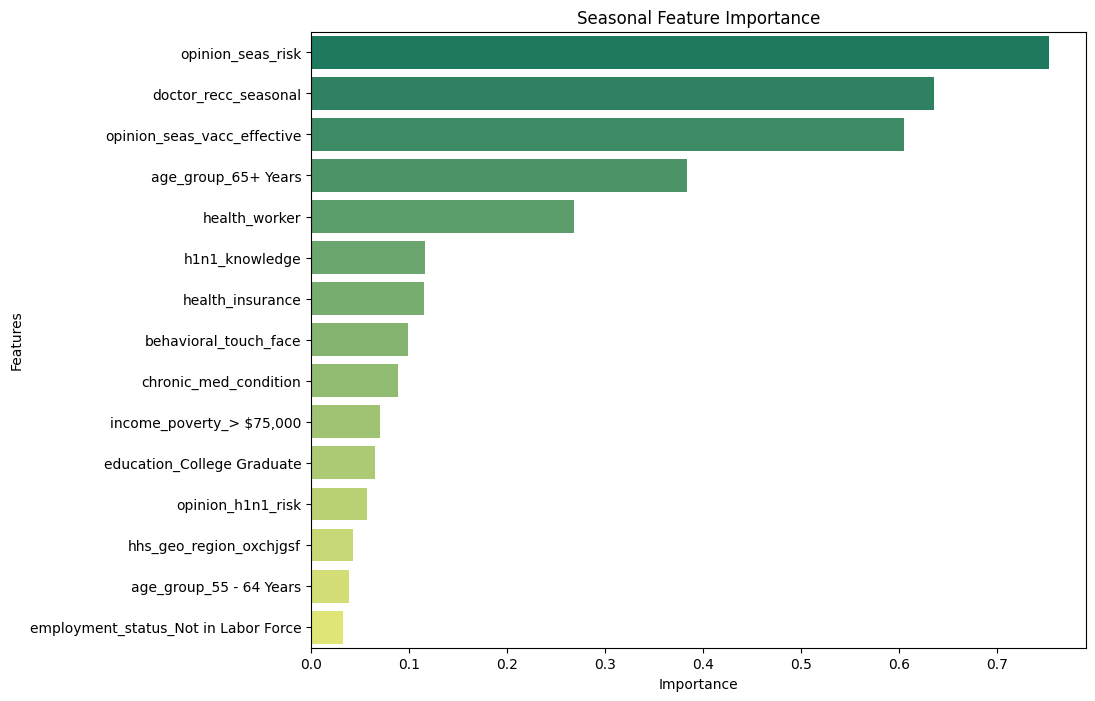

In [95]:
# plot feature importance for seasonal vaccine prediction
fig,ax = plt.subplots(figsize = (10, 8))

sns.barplot(x=seasonal_df_lr['Importance'][:15], y= seasonal_df_lr['Feature'][:15], hue=seasonal_df_lr['Feature'][:15], palette='summer', ax=ax)
ax.set_ylabel('Features')
ax.set_title('Seasonal Feature Importance');

### DECISION TREE CLASSIFIER

Baseline decision tree classifier model

In [96]:
lp_model = DecisionTreeClassifier(criterion='gini', random_state=42)

lp_model.fit(X_train, y_train)
y_pred_lp = lp_model.predict(X_test)

y_test_np = y_test.values
y_pred_lp_np = y_pred_lp

for i in range(y_test_np.shape[1]):
    print(f'Classification Report for Output {i}:')
    print(classification_report(y_test_np[:, i], y_pred_lp_np[:, i], zero_division=0))
    print('\n.......\n')

Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5040
           1       0.42      0.44      0.43      1390

    accuracy                           0.75      6430
   macro avg       0.63      0.64      0.63      6430
weighted avg       0.75      0.75      0.75      6430


.......

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      3441
           1       0.65      0.67      0.66      2989

    accuracy                           0.68      6430
   macro avg       0.68      0.68      0.68      6430
weighted avg       0.68      0.68      0.68      6430


.......



* The h1n1 model is biased toward class 0 as class 1 metrics are all underperforming.
* The seasonal model metrics are quite balanced but the accuracy suggests need for improvement in its predictions.

AUC: {0: np.float64(0.6351854230900994), 1: np.float64(0.6783505032352958)}


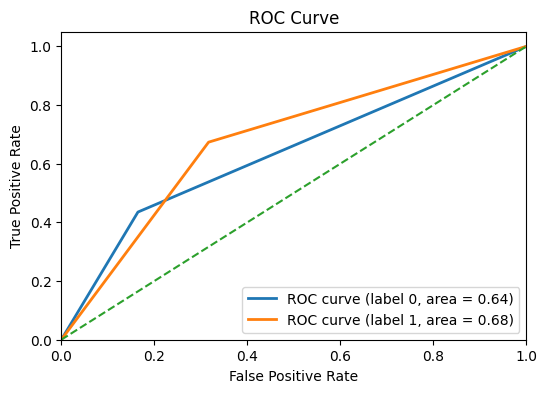

In [97]:
plot_roc_curve(lp_model, X_test, y_test)

* Both AUC scores collaborate our earlier observations about poor prediction capabilities

In [98]:
lp_tuned_model = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', max_depth=10, random_state=42)

lp_tuned_model.fit(X_train, y_train)
y_pred_tuned = lp_tuned_model.predict(X_test)

y_test_np = y_test.values
y_pred_tuned_np = y_pred_tuned

for i in range(y_test_np.shape[1]):
    print(f'Classification Report for Output {i}:')
    print(classification_report(y_test_np[:, i], y_pred_tuned_np[:, i], zero_division=0))
    print('\n.......\n')

Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.90      0.78      0.84      5040
           1       0.46      0.67      0.55      1390

    accuracy                           0.76      6430
   macro avg       0.68      0.73      0.69      6430
weighted avg       0.80      0.76      0.77      6430


.......

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      3441
           1       0.67      0.81      0.73      2989

    accuracy                           0.73      6430
   macro avg       0.74      0.73      0.73      6430
weighted avg       0.74      0.73      0.73      6430


.......



* The accuracy has improved in predicting both vaccines,
* The h1n1 model is still biased towards class 0 as it is better at predicting individuals who did not take the vaccine.



In [99]:
lp_importances = lp_tuned_model.feature_importances_
lp_feature_names = X_train.columns
lp_feature_importance = pd.Series(lp_importances, index=lp_feature_names)
print("\n--- Label Powerset Classifier - Feature Importance ---")
print(lp_feature_importance.sort_values(ascending=False))


--- Label Powerset Classifier - Feature Importance ---
doctor_recc_h1n1                            0.218186
opinion_seas_risk                           0.163892
opinion_seas_vacc_effective                 0.077358
opinion_h1n1_vacc_effective                 0.076199
doctor_recc_seasonal                        0.062194
opinion_h1n1_risk                           0.038043
health_worker                               0.035468
age_group_65+ Years                         0.026149
opinion_seas_sick_from_vacc                 0.018620
age_group_18 - 34 Years                     0.018320
household_children                          0.017696
h1n1_concern                                0.015515
household_adults                            0.014255
h1n1_knowledge                              0.012916
opinion_h1n1_sick_from_vacc                 0.011790
education_Some College                      0.010965
health_insurance                            0.009004
education_< 12 Years                       

In [100]:
threshold = 0.006

selected_features = lp_feature_importance[lp_feature_importance > threshold].index

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


lp_selected_model = DecisionTreeClassifier(criterion='log_loss', max_depth=5, random_state=42)

lp_selected_model.fit(X_train_selected, y_train)
y_pred_selected = lp_selected_model.predict(X_test_selected)

y_test_np = y_test.values
y_pred_selected_np = y_pred_selected

for i in range(y_test_np.shape[1]):
    print(f'Classification Report for Output {i}:')
    print(classification_report(y_test_np[:, i], y_pred_selected_np[:, i], zero_division=0))
    print('\n.......\n')

Classification Report for Output 0:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      5040
           1       0.63      0.44      0.52      1390

    accuracy                           0.82      6430
   macro avg       0.74      0.69      0.71      6430
weighted avg       0.81      0.82      0.81      6430


.......

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79      3441
           1       0.77      0.71      0.74      2989

    accuracy                           0.76      6430
   macro avg       0.76      0.76      0.76      6430
weighted avg       0.76      0.76      0.76      6430


.......



* The h1n1 model has improved significantly but the class 1 f1 score is low meaning it is struggling to balance the output of false positives and false negatives.
* The seasonal model is performing quite well as the metrics are almost balanced meaning it is making relatively even predictions for both classes

In [101]:
param_grid = {
    #'class_weight': ['balanced'],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [5, 8, 10],
}

dtc_model= DecisionTreeClassifier()

grid_search = GridSearchCV(dtc_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train['h1n1_vaccine'])

optimal_params_h1n1 = grid_search.best_params_
print(optimal_params_h1n1)
best_score_h1n1 = grid_search.best_score_
print(best_score_h1n1)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.8280056162213286


In [102]:
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [5, 8, 10],
}

dtc_model= DecisionTreeClassifier()

grid_search = GridSearchCV(dtc_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train['seasonal_vaccine'])

optimal_params_seasonal = grid_search.best_params_
print(optimal_params_seasonal)
best_score_seasonal = grid_search.best_score_
print(best_score_seasonal)

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.7544945068247333


In [103]:
# include class weight to tackle class imbalance
optimal_h1n1_model = DecisionTreeClassifier(criterion='log_loss', max_depth=5, min_samples_leaf=1, class_weight={0:1, 1:2})

optimal_h1n1_model.fit(X_train, y_train['h1n1_vaccine'])
y_pred_h1n1_op = optimal_h1n1_model.predict(X_test)


print(classification_report(y_test['h1n1_vaccine'], y_pred_h1n1, zero_division=0))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      5040
           1       0.70      0.44      0.54      1390

    accuracy                           0.84      6430
   macro avg       0.78      0.70      0.72      6430
weighted avg       0.83      0.84      0.83      6430



In [104]:
# try oversampling class 1
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train['h1n1_vaccine'])
optimal_h1n1_model_im = DecisionTreeClassifier( max_depth=5, min_samples_leaf=1, random_state=42)

optimal_h1n1_model_im.fit(X_train_smote, y_train_smote)
y_pred_h1n1_im = optimal_h1n1_model_im.predict(X_test)


print(classification_report(y_test['h1n1_vaccine'], y_pred_h1n1_im, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5040
           1       0.56      0.58      0.57      1390

    accuracy                           0.81      6430
   macro avg       0.72      0.73      0.73      6430
weighted avg       0.81      0.81      0.81      6430



* The oversampling model has improved balance between precision and recall for both classes even though overall accuracy has dropped

In [105]:
optimal_seasonal_model = DecisionTreeClassifier(max_depth=8, min_samples_split=5)

optimal_seasonal_model.fit(X_train, y_train['seasonal_vaccine'])
y_pred_seasonal_op = optimal_seasonal_model.predict(X_test)

print(classification_report(y_test['seasonal_vaccine'], y_pred_seasonal_op, zero_division=0))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3441
           1       0.77      0.72      0.74      2989

    accuracy                           0.77      6430
   macro avg       0.77      0.76      0.77      6430
weighted avg       0.77      0.77      0.77      6430



* The optimal seasonal model metrics are well balance

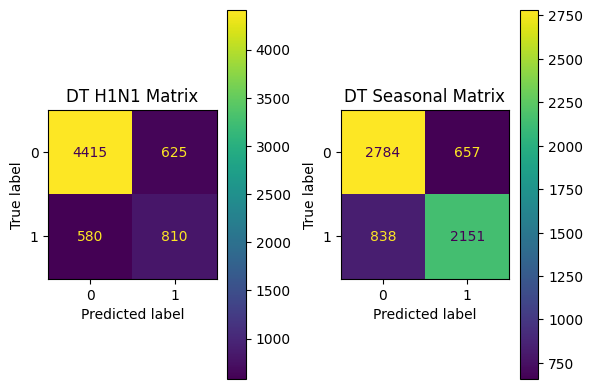

In [106]:
# confusion matrix for optimal h1n1 model
cm_optimal_h1n1_dt = confusion_matrix(y_test['h1n1_vaccine'], y_pred_h1n1_im)

# confusion matrix  for optimal Seasonal vaccine model
cm_optimal_seasonal_dt = confusion_matrix(y_test['seasonal_vaccine'], y_pred_seasonal_op)
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot h1n1 and seasonal vaccine confusion matrix
display_1 = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_h1n1_dt)
display_2 = ConfusionMatrixDisplay(confusion_matrix=cm_optimal_seasonal_dt)

display_1.plot(ax=axes[0])
axes[0].set_title('DT H1N1 Matrix')

display_2.plot(ax=axes[1])
axes[1].set_title('DT Seasonal Matrix')

plt.tight_layout()
plt.show()

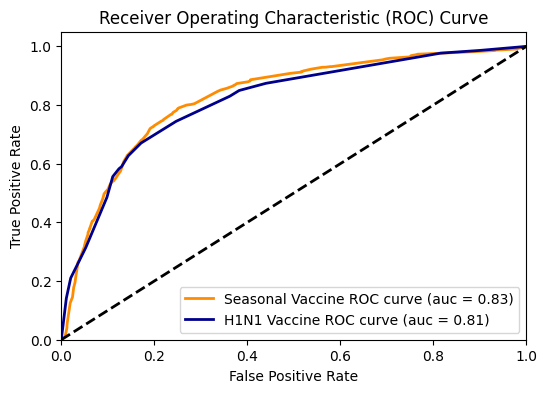

In [107]:
y_pred_proba_h1n1_dt = optimal_h1n1_model_im.predict_proba(X_test)[:, 1]
y_pred_proba_seasonal_dt = optimal_seasonal_model.predict_proba(X_test)[:, 1]

fpr_seasonal, tpr_seasonal, thresholds_seasonal = roc_curve(y_test['seasonal_vaccine'], y_pred_proba_seasonal_dt)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

fpr_h1n1, tpr_h1n1, thresholds_h1n1 = roc_curve(y_test['h1n1_vaccine'], y_pred_proba_h1n1_dt)
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

plt.figure(figsize=(6, 4))
plt.plot(fpr_seasonal, tpr_seasonal, color='darkorange', lw=2, label=f'Seasonal Vaccine ROC curve (auc = {roc_auc_seasonal:.2f})')
plt.plot(fpr_h1n1, tpr_h1n1, color='darkblue', lw=2, label=f'H1N1 Vaccine ROC curve (auc = {roc_auc_h1n1:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [108]:
# creating a dataframe of feature importances
feature_names = X_train.columns.tolist()
importances_h1n1_dt = optimal_h1n1_model.feature_importances_

h1n1_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_h1n1_dt
})
h1n1_df_dt = h1n1_df_dt.sort_values(by='Importance', ascending=False).reset_index(drop=True)

h1n1_df_dt.head(10)

,Feature,Importance
0,doctor_recc_h1n1,0.505109
1,opinion_h1n1_risk,0.206439
2,opinion_h1n1_vacc_effective,0.177667
3,health_worker,0.053660
4,opinion_seas_risk,0.021259
5,h1n1_concern,0.009591
6,doctor_recc_seasonal,0.005210
7,behavioral_avoidance,0.004634
8,sex_Male,0.004063
9,age_group_18 - 34 Years,0.003508


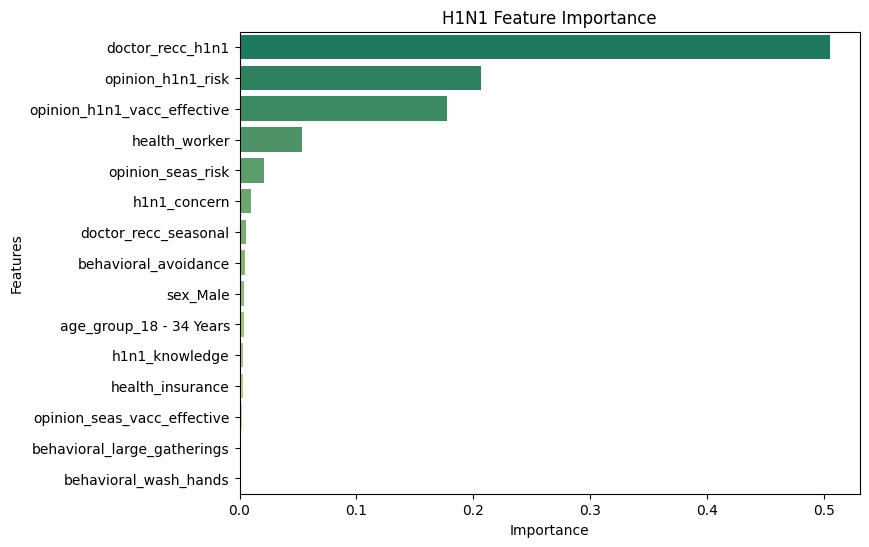

In [109]:
# plot for h1n1 feature importance
fig, ax = plt.subplots(figsize=(8, 6)) 


sns.barplot(x=h1n1_df_dt['Importance'][:15], y=h1n1_df_dt['Feature'][:15], hue=h1n1_df_dt['Feature'][:15], palette='summer', ax=ax)

ax.set_title('H1N1 Feature Importance')
ax.set_ylabel('Features')

plt.show()

In [110]:
feature_names = X_train.columns.tolist()
importances_seasonal_dt = optimal_seasonal_model.feature_importances_

seasonal_df_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_seasonal_dt
})
seasonal_df_dt = seasonal_df_dt.sort_values(by='Importance', ascending=False).reset_index(drop=True)

seasonal_df_dt.head()

,Feature,Importance
0,opinion_seas_risk,0.371984
1,doctor_recc_seasonal,0.188711
2,opinion_seas_vacc_effective,0.156332
3,age_group_65+ Years,0.057222
4,age_group_18 - 34 Years,0.031415


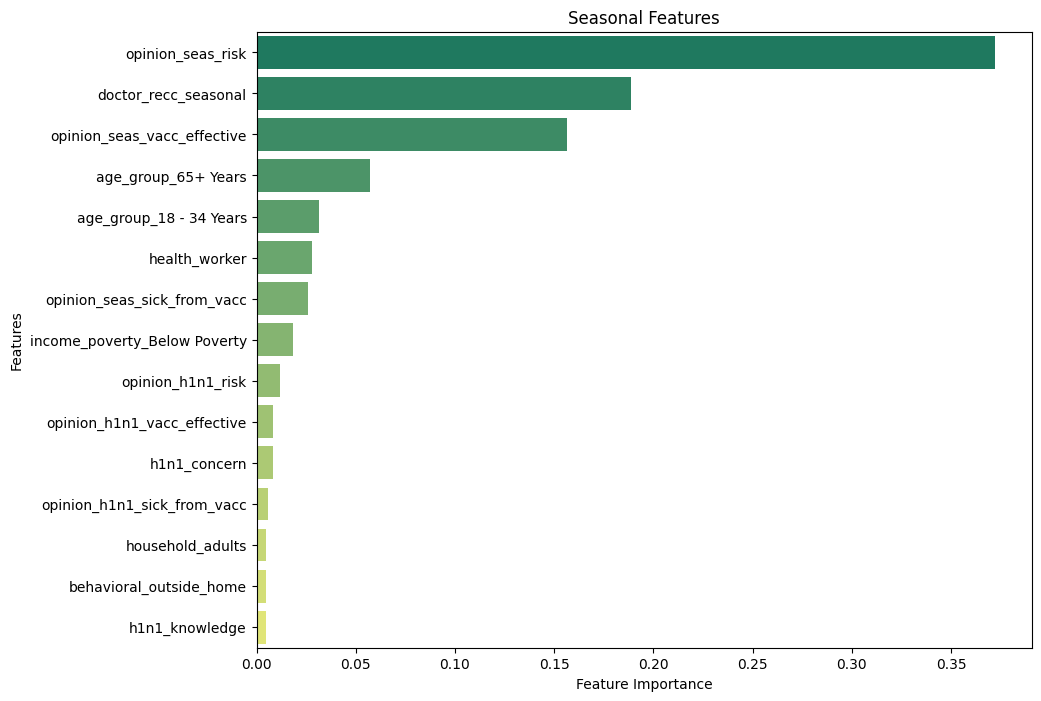

In [111]:
# plot feature importance using dt optimal model
fig, ax = plt.subplots(figsize=(10, 8)) 


sns.barplot(x=seasonal_df_dt['Importance'][:15], y=seasonal_df_dt['Feature'] [:15], hue=seasonal_df_dt['Feature'][:15], palette='summer', ax=ax)

ax.set_title('Seasonal Features')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features');